This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [19]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Activation, Flatten, Dense, Conv2D, MaxPooling2D,Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras import optimizers

In [31]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
cats = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('data/test.csv').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

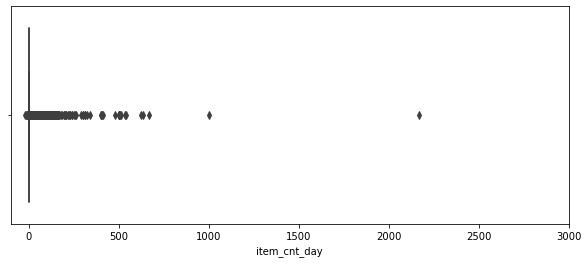

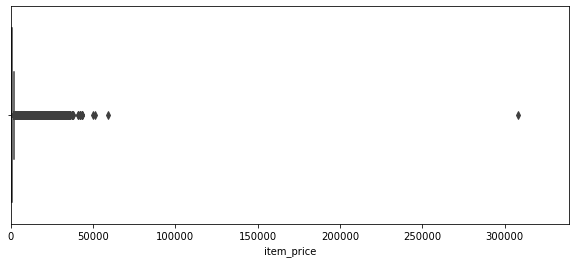

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [5]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [6]:
# Якутск Орджоникидзе, 56
# train.loc[train.shop_id == 0, 'shop_id'] = 57
# test.loc[test.shop_id == 0, 'shop_id'] = 57
# # Якутск ТЦ "Центральный"
# train.loc[train.shop_id == 1, 'shop_id'] = 58
# test.loc[test.shop_id == 1, 'shop_id'] = 58
# # Жуковский ул. Чкалова 39м²
# train.loc[train.shop_id == 10, 'shop_id'] = 11
# test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [8]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [9]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
# 34 Month
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

7.099481582641602

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [10]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [11]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

2.8926849365234375

## Test set
To use time tricks append test pairs to the matrix.

In [12]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [13]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.03266787528991699

## Shops/Items/Cats features

In [14]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

2.2173824310302734

## Traget lags

In [15]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [16]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

19.989157915115356

## Mean encoded features

In [17]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

5.936475515365601

In [18]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.951314449310303

In [19]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

22.077864170074463

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.367623805999756

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.579327583312988

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.476703405380249

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.622546672821045

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.474397897720337

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

12.067018985748291

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

8.05081844329834

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

8.186474800109863

## Trend features

Price trend for the last six months.

In [28]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

254.85673475265503

Last month shop revenue trend

In [29]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

10.277363300323486

## Special features

In [30]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [31]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [32]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1146.000747203827

In [33]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

751.821417093277

Months since the first sale for each shop/item pair and for item only.

In [34]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.0890347957611084

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [35]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

0.49147987365722656

Producing lags brings a lot of nulls.

In [36]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.191007137298584

In [37]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [38]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [39]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [19]:
data

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.089050,0.096008,0.141235,1.082031,0.955566,0.148071,0.0,-0.282715,0,31,1,1,12,12
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.411377,1.021484,1.022461,0.521973,0.891113,0.000000,0.148071,0.100647,0.089050,0.096008,0.000000,0.291504,0.046234,0.148071,0.0,-0.483398,0,31,1,1,11,11
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,0.0,0.411377,0.543457,0.600098,0.543457,0.304443,0.000000,0.148071,0.100647,0.089050,0.096008,0.000000,0.232788,0.059448,0.148071,0.0,-0.137451,0,31,1,1,11,11
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.411377,1.934570,1.799805,1.260742,1.891602,5.378906,0.148071,0.100647,0.089050,0.096008,0.141235,0.291504,0.046234,0.148071,0.0,-0.407227,0,31,-1,1,12,12
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,0.0,0.0,1.0,0.411377,0.913086,0.333252,0.717285,1.000000,1.355469,0.148071,0.100647,0.089050,0.096008,0.141235,0.232788,0.059448,0.148071,1.0,-0.225464,0,31,1,1,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.258545,0.045441,0.023254,0.071411,0.590820,0.000000,0.126709,0.128784,0.139038,0.137573,0.000000,0.196899,0.126831,0.135376,0.5,-0.475098,10,30,1,-1,11,11
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,0.0,0.0,0.0,0.258545,0.022720,0.069763,0.000000,0.000000,0.000000,0.126709,0.128784,0.000000,0.000000,0.000000,0.155884,0.094482,0.135376,0.0,0.081116,10,30,-1,-1,2,2
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.258545,0.113647,0.069763,0.095215,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.196899,0.126831,0.135376,0.0,0.155884,10,30,1,-1,34,34
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.258545,0.045441,0.069763,0.166626,0.090881,0.000000,0.126709,0.128784,0.139038,0.137573,0.000000,0.220825,0.083740,0.135376,0.0,-0.091736,10,30,-1,-1,11,11


In [3]:
data = pd.read_pickle('data.pkl')
#data2 = pd.read_pickle('feature3.pkl')

Select perfect features

In [4]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [15]:
data2=data2.dropna()

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [17]:
X_train2 = data2[data2.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train2 = data2[data2.date_block_num < 33]['item_cnt_month']
X_valid2 = data2[data2.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid2 = data2[data2.date_block_num == 33]['item_cnt_month']
X_test2= data2[data2.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
del data
gc.collect();

XGBoost

In [18]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid2, Y_valid2)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[21:31:01] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:3.33614	validation_1-rmse:2.64041
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.06523	validation_1-rmse:2.40099
[2]	validation_0-rmse:2.85696	validation_1-rmse:2.21518
[3]	validation_0-rmse:2.76896	validation_1-rmse:2.18350
[4]	validation_0-rmse:2.67242	validation_1-rmse:2.10241
[5]	validation_0-rmse:2.63044	validation_1-rmse:2.07067
[6]	validation_0-rmse:2.60389	validation_1-rmse:2.07551
[7]	validation_0-rmse:2.58082	validation_1-rmse:2.09037
[8]	validation_0-rmse:2.53978	validation_1-rmse:2.06228
[9]	validation_0-rmse:2.51858	validation_1-rmse:2.05637
[10]	validation_0-rmse:2.50383	validation_1-rmse:2.06199
[11]	va

KeyboardInterrupt: 

In [45]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

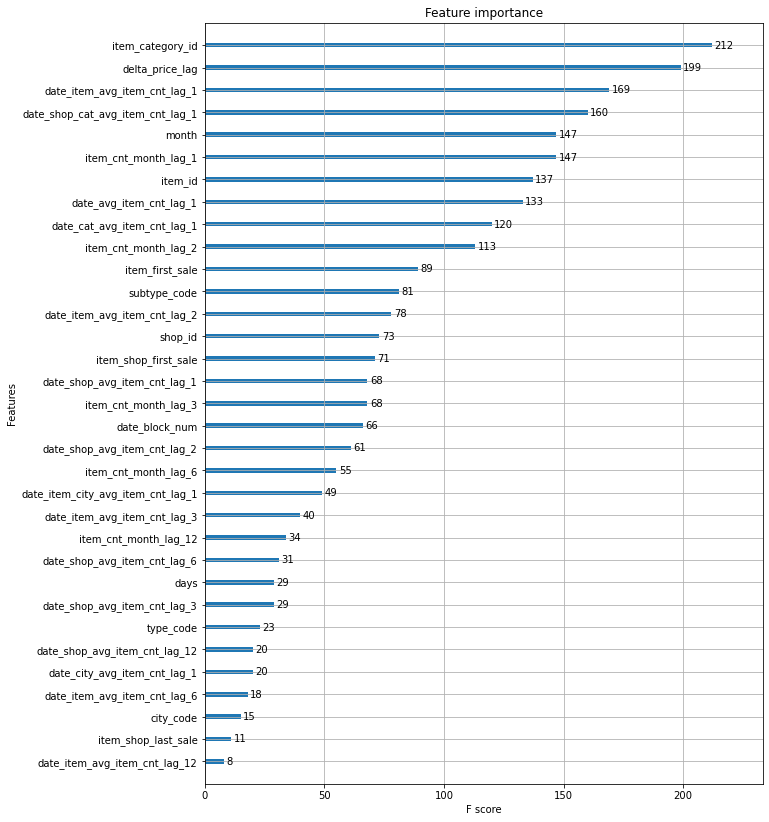

In [46]:
plot_features(model, (10,14))

MLP

In [26]:
epochs = 10
batch = 256
lr = 0.001
adam = optimizers.Adam(lr)

In [59]:
model_mlp = Sequential()
model_mlp.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               7000      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________


In [60]:
mlp_history = model_mlp.fit(X_train.values, Y_train, 
                            validation_data=(X_valid.values, Y_valid), 
                            epochs=10, verbose=2)

Epoch 1/10
193342/193342 - 173s - loss: 7.5081 - val_loss: 3.5121
Epoch 2/10
193342/193342 - 173s - loss: 3.9255 - val_loss: 1.5931
Epoch 3/10
193342/193342 - 172s - loss: 3.0691 - val_loss: 1.4595
Epoch 4/10
193342/193342 - 174s - loss: 2.3201 - val_loss: 1.1575
Epoch 5/10
193342/193342 - 172s - loss: 1.8743 - val_loss: 1.0306
Epoch 6/10
193342/193342 - 173s - loss: 1.5698 - val_loss: 2.5214
Epoch 7/10
193342/193342 - 171s - loss: 1.3458 - val_loss: 0.9420
Epoch 8/10
193342/193342 - 164s - loss: 1.1197 - val_loss: 1.1396
Epoch 9/10
193342/193342 - 171s - loss: 0.9982 - val_loss: 1.2840
Epoch 10/10
193342/193342 - 171s - loss: 0.9087 - val_loss: 0.9837


In [78]:
pd.DataFrame(model_mlp.predict(X_test))[0]

0         0.534805
1         1.043633
2         1.112598
3         0.392815
4         2.603654
            ...   
214195    0.699285
214196    0.447675
214197    0.364526
214198    0.464225
214199    0.082008
Name: 0, Length: 214200, dtype: float32

In [80]:
Y_pred = model_mlp.predict(X_valid).clip(0, 20)
Y_test = model_mlp.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": pd.DataFrame(model_mlp.predict(X_test))[0]
})
submission.to_csv('mlp_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('mlp_train.pickle', 'wb'))
pickle.dump(Y_test, open('mlp_test.pickle', 'wb'))
#plot_features(model_mlp, (10,14))

CNN

In [15]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (6186922, 34, 1)
Validation set shape (238172, 34, 1)


In [27]:
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 33, 64)            192       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 32, 64)            8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [28]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=20, verbose=2)

Epoch 1/10
193342/193342 - 257s - loss: 20.2058 - val_loss: 0.9430
Epoch 2/10
193342/193342 - 246s - loss: 0.8304 - val_loss: 0.9321
Epoch 3/10
193342/193342 - 239s - loss: 0.8287 - val_loss: 0.9432
Epoch 4/10
193342/193342 - 252s - loss: 0.8330 - val_loss: 0.9535
Epoch 5/10
193342/193342 - 253s - loss: 0.8159 - val_loss: 0.9000
Epoch 6/10
193342/193342 - 260s - loss: 0.8132 - val_loss: 0.9182
Epoch 7/10
193342/193342 - 264s - loss: 0.8145 - val_loss: 0.9003
Epoch 8/10
193342/193342 - 258s - loss: 0.8124 - val_loss: 0.8915
Epoch 9/10
193342/193342 - 257s - loss: 0.8138 - val_loss: 0.9187
Epoch 10/10
193342/193342 - 253s - loss: 0.8111 - val_loss: 0.9115


In [32]:
X_valid_cnn_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print(X_valid_cnn_series.shape)
X_test_cnn_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_cnn_series.shape)

Y_pred = model_cnn.predict(X_valid_cnn_series).clip(0, 20)
Y_test = model_cnn.predict(X_test_cnn_series).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test.flatten()
})
submission.to_csv('cnn_submission2.csv', index=False)
Y_test.to_csv('cnn_Y_test.csv')
Y_pred.to_csv('cnn_Y_pred.csv')

# save predictions for an ensemble
pickle.dump(Y_pred, open('cnn_train.pickle', 'wb'))
pickle.dump(Y_test, open('cnn_test.pickle', 'wb'))
#plot_features(model_mlp, (10,14))

(238172, 34, 1)
(214200, 34, 1)


In [44]:
cnn_pred = model_cnn.predict(X_valid_cnn_series).clip(0, 20)
cnn_test = model_cnn.predict(X_test_cnn_series).clip(0, 20)
pickle.dump(cnn_pred, open('cnn_pred.pickle', 'wb'))
pickle.dump(cnn_test, open('cnn_test.pickle', 'wb'))

In [33]:
X_train_series = X_train.values.reshape((X_train.shape[0], 2, int(X_train.shape[1]/2)))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], 2, int(X_valid.shape[1]/2)))
print(X_train_series.shape)
print(X_valid_series.shape)

(6186922, 2, 17)
(238172, 2, 17)


In [35]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13600     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 13,651
Trainable params: 13,651
Non-trainable params: 0
_________________________________________________________________


In [38]:
# lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=20, verbose=2)

 CNN-LSTM

In [39]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [40]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (6186922, 2, 17, 1)
Validation set shape (238172, 2, 17, 1)


In [42]:
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(Dropout(0.5)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dropout(0.5))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [43]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=10, verbose=2)

Epoch 1/10
193342/193342 - 617s - loss: 2.1607 - val_loss: 0.9656
Epoch 2/10
193342/193342 - 610s - loss: 0.9906 - val_loss: 1.0023
Epoch 3/10
193342/193342 - 610s - loss: 0.9523 - val_loss: 0.9256
Epoch 4/10
193342/193342 - 614s - loss: 0.9288 - val_loss: 0.8955
Epoch 5/10
193342/193342 - 609s - loss: 0.9341 - val_loss: 0.9015
Epoch 6/10
193342/193342 - 610s - loss: 1.0146 - val_loss: 0.9938
Epoch 7/10
193342/193342 - 604s - loss: 1.4237 - val_loss: 0.9159
Epoch 8/10
193342/193342 - 598s - loss: 1.1021 - val_loss: 0.9247
Epoch 9/10
193342/193342 - 595s - loss: 0.9205 - val_loss: 0.9371
Epoch 10/10
193342/193342 - 622s - loss: 0.9002 - val_loss: 0.9048


In [56]:
#subsequences = 2
#timesteps = X_test_cnn_series.shape[1]//subsequences
X_test_series_comb = X_test_cnn_series.reshape((X_test_cnn_series.shape[0], subsequences, X_test_cnn_series.shape[1]//subsequences, 1))
X_valid_series_comb = X_valid_cnn_series.reshape((X_valid_cnn_series.shape[0], subsequences, X_valid_cnn_series.shape[1]//subsequences, 1))

cnn_lstm_pred = model_cnn_lstm.predict(X_valid_series_comb).clip(0, 20)
cnn_lstm_test = model_cnn_lstm.predict(X_test_series_comb).clip(0, 20)
pickle.dump(cnn_lstm_pred, open('cnn_lstm_pred.pickle', 'wb'))
pickle.dump(cnn_lstm_test, open('cnn_lstm_test.pickle', 'wb'))

In [ ]:
subsequences = 2
timesteps = X_test_cnn_series.shape[1]//subsequences
X_test_series_comb = X_test_cnn_series.reshape((X_test_cnn_series.shape[0], subsequences, timesteps, 1))

#Y_pred = model_cnn.predict(X_valid_cnn_series).clip(0, 20)
Y_test = model_cnn.predict(X_test_series_comb).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test.flatten()
})
submission.to_csv('cnn_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('cnn_train.pickle', 'wb'))
pickle.dump(Y_test, open('cnn_test.pickle', 'wb'))
#plot_features(model_mlp, (10,14))